In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from IPython.display import display


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\lenau\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PCA_Palmer'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

In [3]:
def select_optimal_lv(calibration, validation):
    min_diff = float('inf')
    optimal_lv = 1
    max_lv = 10

    for lv in range(2, max_lv + 1):
        diff_cal = abs(calibration.loc[lv, 'r2_cal'] - calibration.loc[lv - 1, 'r2_cal'])
        diff_val = abs(validation.loc[lv, 'r2_cv'] - validation.loc[lv - 1, 'r2_cv'])
        
        avg_diff = (diff_cal + diff_val) / 2

        if avg_diff < min_diff:
            min_diff = avg_diff
            optimal_lv = lv

    return optimal_lv

def train_model(X_scaled, Y_scaled, max_lv=10):
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pca = PCA(n_components=lv)
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()

        # Calibração do modelo
        lin_reg.fit(X_pca, Y_scaled)
        predictions_train = lin_reg.predict(X_pca)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        Y_scaled_reshaped = Y_scaled.reshape(-1)
        predictions_train_reshaped = predictions_train.reshape(-1)

        # Calcular a correlação
        correlation_cal = np.corrcoef(Y_scaled_reshaped, predictions_train_reshaped)[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train_reshaped

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(lin_reg, X_pca, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        predictions_cv_reshaped = predictions_cv.reshape(-1)

        # Calcular a correlação para validação cruzada
        correlation_cv = np.corrcoef(Y_scaled_reshaped, predictions_cv_reshaped)[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv_reshaped
    
    # Selecionar o número ideal de componentes latentes baseado na menor variação de R²
    optimal_lv = select_optimal_lv(calibration, validation)
    
    pca = PCA(n_components=optimal_lv)
    X_pca = pca.fit_transform(X_scaled)
    lin_reg = LinearRegression()
    model = lin_reg.fit(X_pca, Y_scaled)

    return calibration, validation, optimal_lv, model, pca, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, pca, X_pred, y_pred, lv_number):
    #X_centered, _, _, _ = center_data(X_pred.iloc[:, 6:].values, y_pred.values)
    X_centered = X_pred.iloc[:, 8:].values
    X_pred_pca = pca.transform(X_centered)  # Transformar dados de teste com PCA
    
    pred = model.predict(X_pred_pca)
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_p', 'neg_root_mean_squared_error_p', 'explained_variance_p', 'correlation_p', 'rpearson_p', 'bias_p', 'sec_p'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred.flatten(), pred.flatten())[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred.flatten(), pred.flatten())[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[:, 0].tolist()
    
    return prediction, Y_predict


def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'R²': [r2_opt, r2_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'Offset': [offset_opt, offset_pred],
    'Slope': [slope_opt,slope_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)

    # Adicionar linha de calibração para valores otimizados (Y_opt)
    plt.plot(Y_true, slope_opt * Y_true + offset_opt, color='blue', linestyle='--', label=f'Calibração (Slope={slope_opt:.2f}, Offset={offset_opt:.2f})')

    # Adicionar linha de calibração para valores preditos (Y_pred)
    plt.plot(Y_true, slope_pred * Y_true + offset_pred, color='red', linestyle='--', label=f'Predição (Slope={slope_pred:.2f}, Offset={offset_pred:.2f})')
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
            transform=plt.gca().transAxes, verticalalignment='top')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    metrics_dict = pd.DataFrame({
    'Y': ['Validação'],
    'R²': [r2],
    'RMSE': [rmse],
    'Offset': [offset],
    'Slope': [slope]
    })
    
    return metrics_dict


def build_model(X_cal, Y_cal, X_val, Y_val):
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    calibration, validation, lv_num, model, pca, Y_values = train_model(X.iloc[:,8:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, pca, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    #display(chart_data)
    plot_infos_p = pred_plot(Y_predict)
    #display(Y_predict)
    plot_infos_df = plot_infos.copy()
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_df, plot_infos_p], ignore_index=True)
    
    
    
    return calibration, validation, Y_predict, plot_infos_pre

In [4]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])
plot_infos_raw = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'RMSE','Offset','Slope'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre

In [5]:
print(df_raw_cal.columns)

Index([   'Amostra',        'SST',    'FIRMEZA',        'ATT',        'AAC',
       'MASSA SECA',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)


Número de componentes: 2


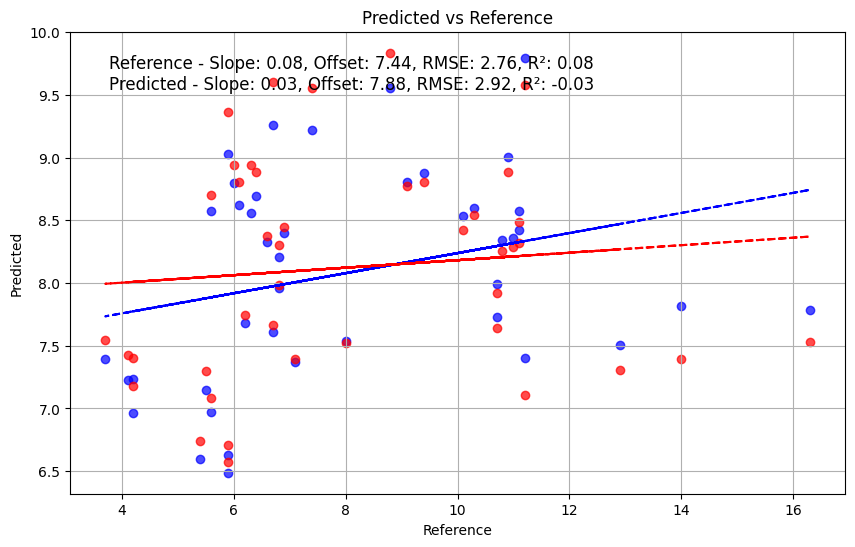

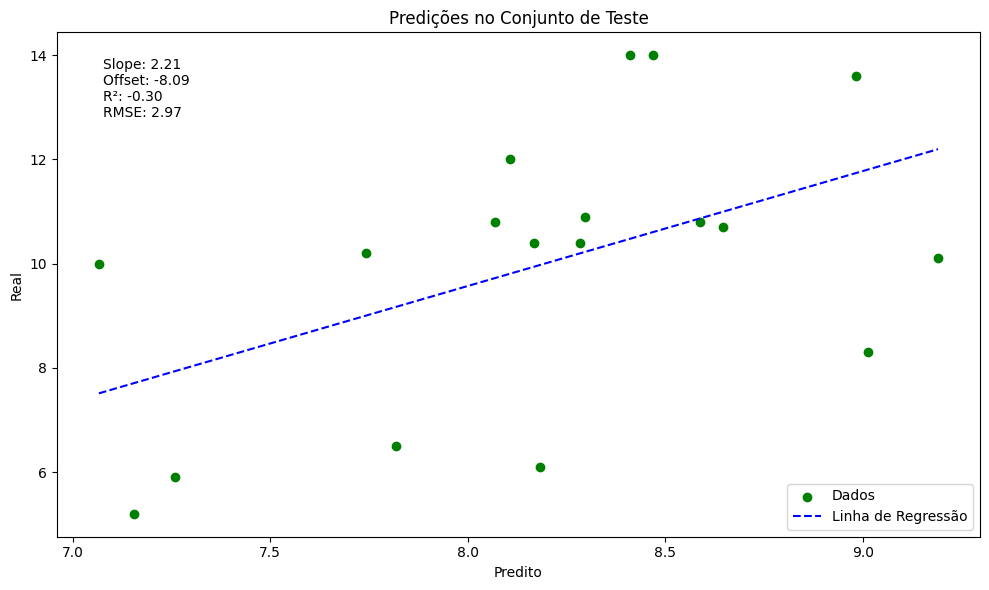

In [6]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'SST')

Número de componentes: 7


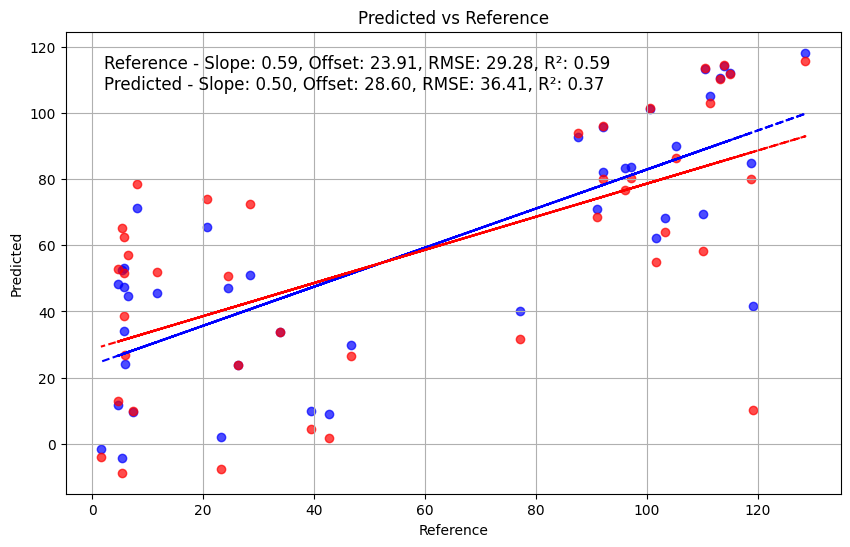

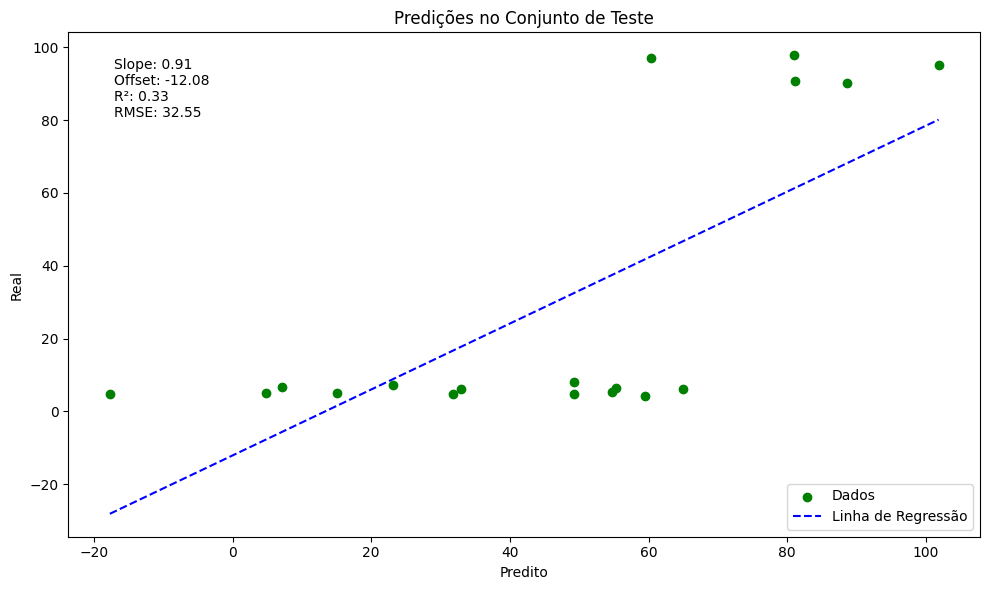

In [7]:
calibration_msc_firmeza, validation_msc_firmeza, Y_predict_msc_firmeza, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA'], df_msc_val, df_msc_val['FIRMEZA'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA')

Número de componentes: 9


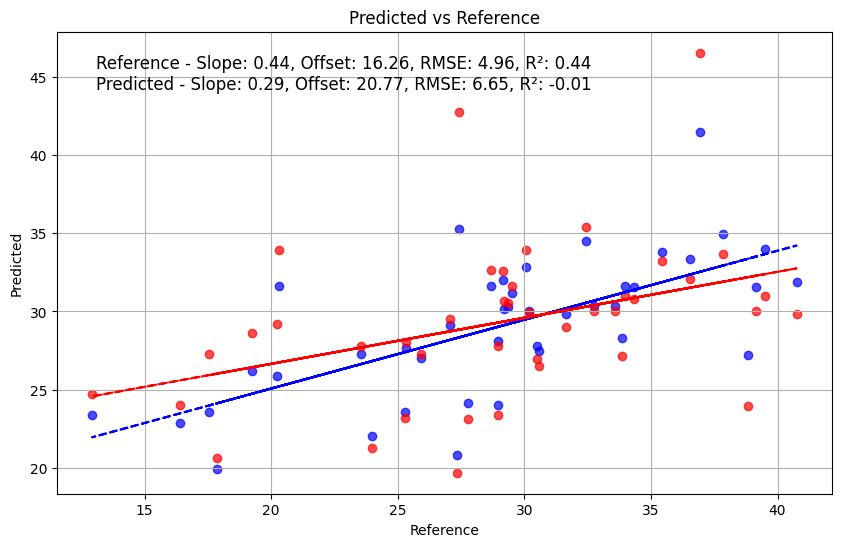

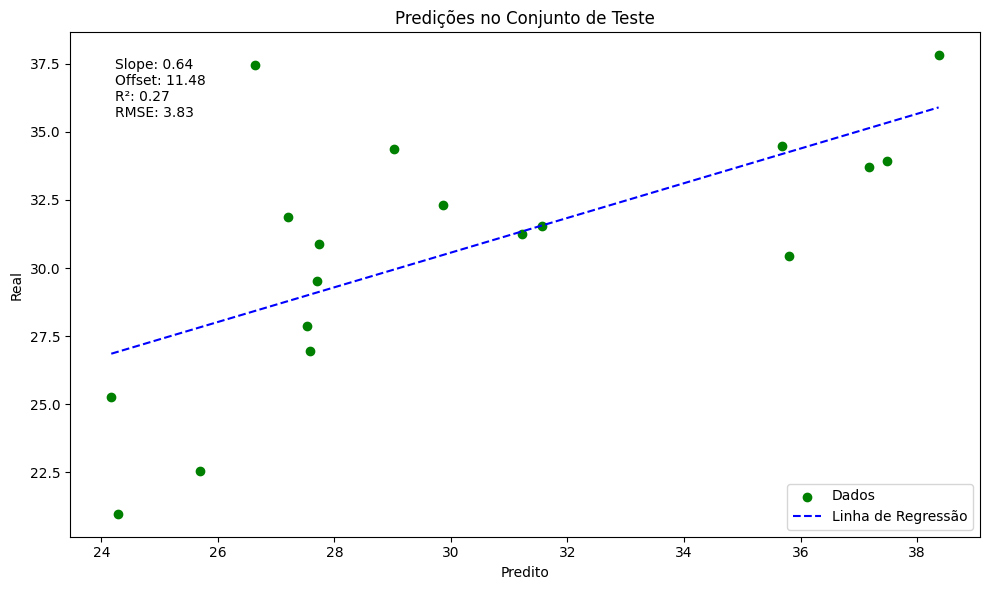

In [8]:
calibration_msc_aac, validation_msc_aac, Y_predict_msc_aac, plot_infos = build_model(df_msc_cal, df_msc_cal['AAC'], df_msc_val, df_msc_val['AAC'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AAC')

Número de componentes: 10


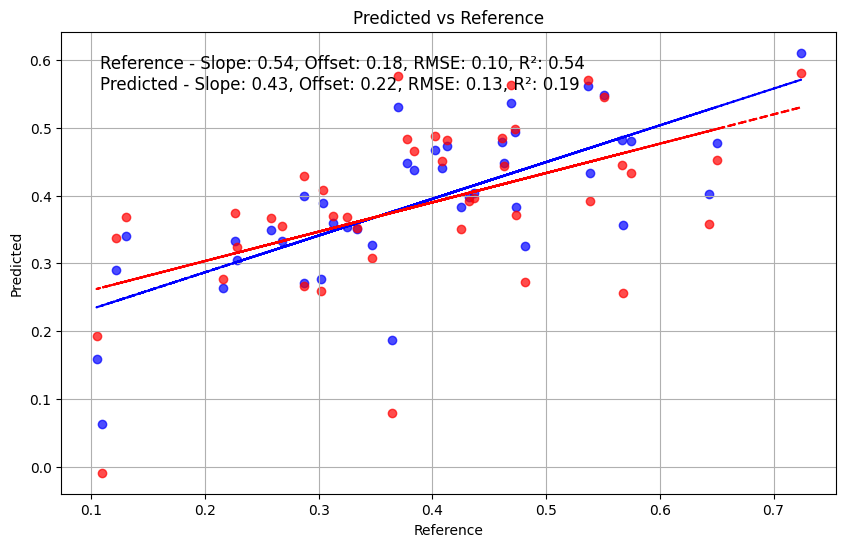

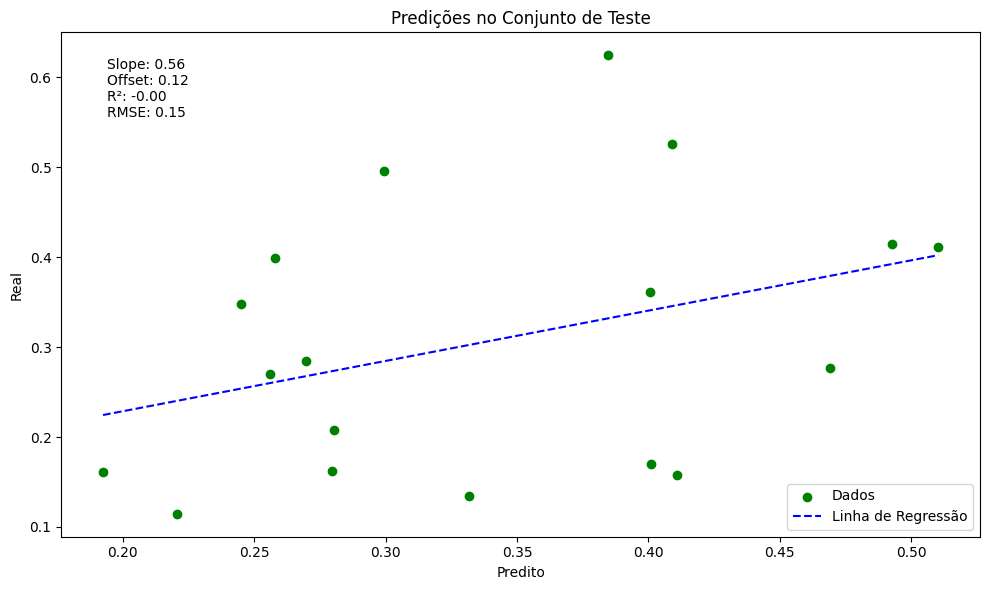

In [9]:
calibration_msc_att, validation_msc_att, Y_predict_msc_att, plot_infos = build_model(df_msc_cal, df_msc_cal['ATT'], df_msc_val, df_msc_val['ATT'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'ATT')

Número de componentes: 5


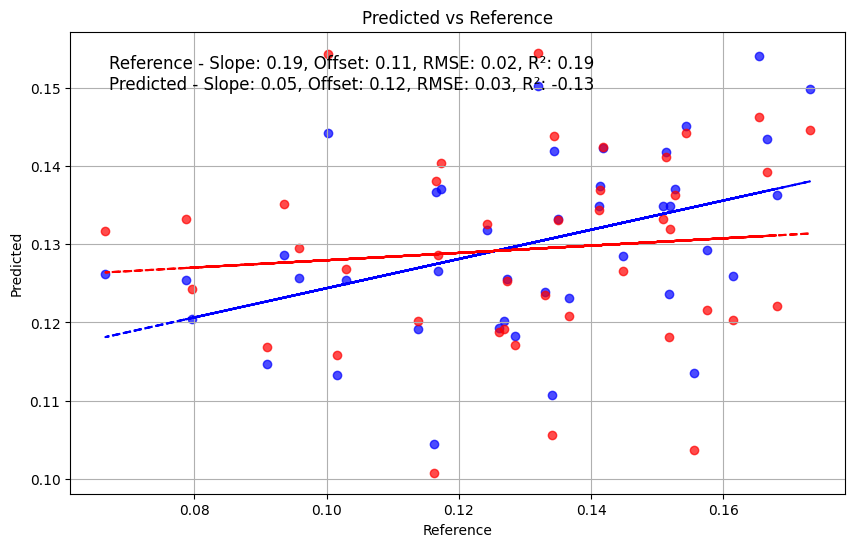

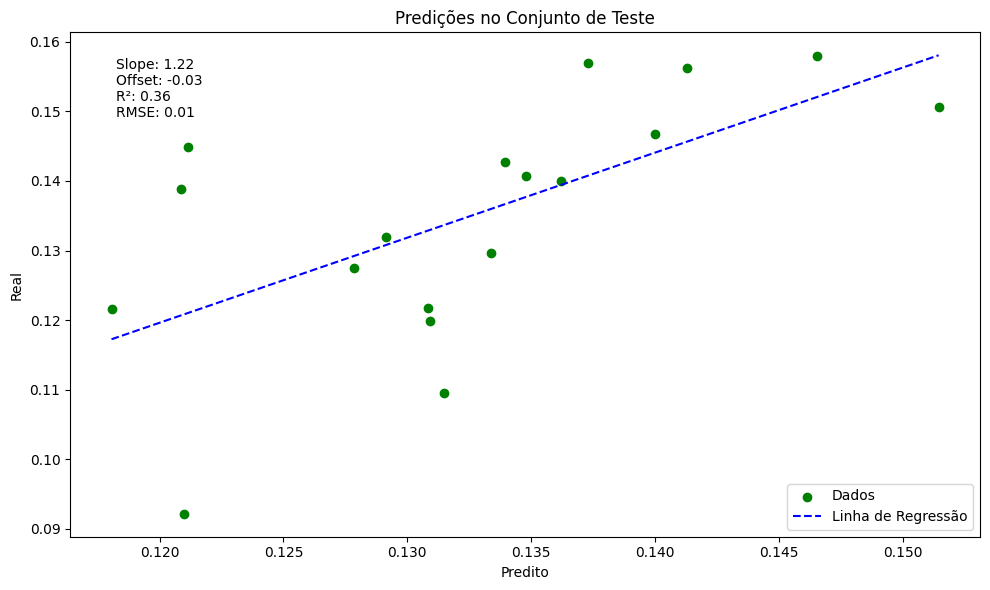

In [10]:
calibration_msc_ubs, validation_msc_ubs, Y_predict_msc_ubs, plot_infos = build_model(df_msc_cal, df_msc_cal['MASSA SECA'], df_msc_val, df_msc_val['MASSA SECA'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'MASSA SECA')

In [11]:
plot_infos_msc.to_excel('plot_infos_pcr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.080039,2.764348,7.438539,0.080039
1,SST,Predição,-0.026805,2.920465,7.883843,0.029863
2,SST,Validação,-0.300948,2.970766,-8.085911,2.207231
3,FIRMEZA,Referência,0.589785,29.284666,23.906766,0.589785
4,FIRMEZA,Predição,0.365922,36.408734,28.596783,0.500247
5,FIRMEZA,Validação,0.325462,32.546181,-12.082435,0.905059
6,AAC,Referência,0.440706,4.959910,16.256630,0.440706
7,AAC,Predição,-0.005303,6.649703,20.768629,0.294174
8,AAC,Validação,0.270498,3.830532,11.476011,0.636304
9,ATT,Referência,0.542261,0.100276,0.178169,0.542261


In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Usar um backend não interativo adequado para salvar gráficos
import matplotlib
matplotlib.use('Agg')

# Diretório onde os gráficos serão salvos
GRAPH_FOLDER = 'graphs_msc'
if not os.path.exists(GRAPH_FOLDER):
    os.makedirs(GRAPH_FOLDER)

# Função para salvar gráficos corretamente
def save_plot(title):
    filename = f"{title.replace(' ', '_').lower()}.png"
    filepath = os.path.join(GRAPH_FOLDER, filename)
    
    # Forçar o gráfico a ser desenhado completamente antes de salvar
    plt.draw()
    
    # Salvar o gráfico com 'bbox_inches' para garantir que não haja cortes
    plt.savefig(filepath, bbox_inches='tight')
    print(f"Gráfico salvo em: {filepath}")
    
    # Fechar o gráfico para evitar sobreposição
    plt.close()

# Função para gerar o gráfico de "Predições no Conjunto de Teste" e salvar
def pred_plot(Y_predict, title="Predicoes_no_Conjunto_de_Teste"):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    # Geração do gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.95, 0.05, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')
    plt.tight_layout()
    
    # Salvar o gráfico
    save_plot(title)

    metrics_dict = pd.DataFrame({
        'Y': ['Validação'],
        'R²': [r2],
        'RMSE': [rmse],
        'Offset': [offset],
        'Slope': [slope]
    })
    
    #return metrics_dict


# Exemplo de chamada para o gráfico de SST
# Primeiro gráfico: Predicted vs Reference
plt.figure()  # Inicia uma nova figura
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'SST')
save_plot("SST_Predicted_vs_Reference")  # Salva o gráfico de "Predicted vs Reference"

# Segundo gráfico: Predições no Conjunto de Teste
pred_plot(Y_predict_msc_sst, "SST_Predicoes_no_Conjunto_de_Teste")  # Salva o gráfico de "Predições no Conjunto de Teste"


# Repita o mesmo para os outros parâmetros
# FIRMEZA
plt.figure()
calibration_msc_firmeza, validation_msc_firmeza, Y_predict_msc_firmeza, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA'], df_msc_val, df_msc_val['FIRMEZA'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA')
save_plot("Firmeza_Predicted_vs_Reference")
pred_plot(Y_predict_msc_firmeza, "Firmeza_Predicoes_no_Conjunto_de_Teste")

# AAC
plt.figure()
calibration_msc_aac, validation_msc_aac, Y_predict_msc_aac, plot_infos = build_model(df_msc_cal, df_msc_cal['AAC'], df_msc_val, df_msc_val['AAC'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AAC')
save_plot("AAC_Predicted_vs_Reference")
pred_plot(Y_predict_msc_aac, "AAC_Predicoes_no_Conjunto_de_Teste")

# ATT
plt.figure()
calibration_msc_att, validation_msc_att, Y_predict_msc_att, plot_infos = build_model(df_msc_cal, df_msc_cal['ATT'], df_msc_val, df_msc_val['ATT'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'ATT')
save_plot("ATT_Predicted_vs_Reference")
pred_plot(Y_predict_msc_att, "ATT_Predicoes_no_Conjunto_de_Teste")

# MASSA SECA
plt.figure()
calibration_msc_ubs, validation_msc_ubs, Y_predict_msc_ubs, plot_infos = build_model(df_msc_cal, df_msc_cal['MASSA SECA'], df_msc_val, df_msc_val['MASSA SECA'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'MASSA SECA')
save_plot("Massa_Seca_Predicted_vs_Reference")
pred_plot(Y_predict_msc_ubs, "Massa_Seca_Predicoes_no_Conjunto_de_Teste")

Número de componentes: 2
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_msc\sst_predicted_vs_reference.png
Gráfico salvo em: graphs_msc\sst_predicoes_no_conjunto_de_teste.png
Número de componentes: 7
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_msc\firmeza_predicted_vs_reference.png
Gráfico salvo em: graphs_msc\firmeza_predicoes_no_conjunto_de_teste.png
Número de componentes: 9
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_msc\aac_predicted_vs_reference.png
Gráfico salvo em: graphs_msc\aac_predicoes_no_conjunto_de_teste.png
Número de componentes: 10
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_msc\att_predicted_vs_reference.png
Gráfico salvo em: graphs_msc\att_predicoes_no_conjunto_de_teste.png
Número de componentes: 5
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_msc\massa

In [13]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['SST'], df_snv_val, df_snv_val['SST'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'SST')

Número de componentes: 5
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png


In [14]:
calibration_snv_firmeza, validation_snv_firmeza, Y_predict_snv_firmeza, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA'], df_snv_val, df_snv_val['FIRMEZA'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA')

Número de componentes: 7
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png


In [15]:
calibration_snv_aac, validation_snv_aac, Y_predict_snv_aac, plot_infos = build_model(df_snv_cal, df_snv_cal['AAC'], df_snv_val, df_snv_val['AAC'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AAC')

Número de componentes: 9
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png


In [16]:
calibration_snv_att, validation_snv_att, Y_predict_snv_att, plot_infos = build_model(df_snv_cal, df_snv_cal['ATT'], df_snv_val, df_snv_val['ATT'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'ATT')

Número de componentes: 2
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png


In [17]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['MASSA SECA'], df_snv_val, df_snv_val['MASSA SECA'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'MASSA SECA')

Número de componentes: 5
Gráfico salvo em: graphs_msc\predicoes_no_conjunto_de_teste.png


In [18]:
plot_infos_snv.to_excel('plot_infos_pcr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.358834,2.290450,5.214814,0.358834
1,SST,Predição,0.115348,2.690432,6.075488,0.255481
2,FIRMEZA,Referência,0.579300,29.644573,24.508257,0.579300
3,FIRMEZA,Predição,0.365467,36.407120,29.460107,0.490233
4,AAC,Referência,0.434083,4.975522,16.506986,0.434083
5,AAC,Predição,-0.037108,6.735572,21.110555,0.283107
6,ATT,Referência,0.027600,0.137884,0.373825,0.027600
7,ATT,Predição,-0.105734,0.147033,0.396215,-0.035195
8,MASSA SECA,Referência,0.185518,0.023370,0.106748,0.185518
9,MASSA SECA,Predição,-0.160395,0.027894,0.125806,0.036396


In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Usar um backend não interativo adequado para salvar gráficos
import matplotlib
matplotlib.use('Agg')

# Diretório onde os gráficos serão salvos
GRAPH_FOLDER = 'graphs_snv'
if not os.path.exists(GRAPH_FOLDER):
    os.makedirs(GRAPH_FOLDER)

# Função para salvar gráficos corretamente
def save_plot(title):
    filename = f"{title.replace(' ', '_').lower()}.png"
    filepath = os.path.join(GRAPH_FOLDER, filename)
    
    # Forçar o gráfico a ser desenhado completamente antes de salvar
    plt.draw()
    
    # Salvar o gráfico com 'bbox_inches' para garantir que não haja cortes
    plt.savefig(filepath, bbox_inches='tight')
    print(f"Gráfico salvo em: {filepath}")
    
    # Fechar o gráfico para evitar sobreposição
    plt.close()

# Função para gerar o gráfico de "Predições no Conjunto de Teste" e salvar
def pred_plot(Y_predict, title="Predicoes_no_Conjunto_de_Teste"):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    # Geração do gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.95, 0.05, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')
    plt.tight_layout()
    
    # Salvar o gráfico
    save_plot(title)

    metrics_dict = pd.DataFrame({
        'Y': ['Validação'],
        'R²': [r2],
        'RMSE': [rmse],
        'Offset': [offset],
        'Slope': [slope]
    })
    
    #return metrics_dict


# Exemplo de chamada para o gráfico de SST
# Primeiro gráfico: Predicted vs Reference
plt.figure()  # Inicia uma nova figura
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['SST'], df_snv_val, df_snv_val['SST'])
plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'SST')
save_plot("SST_Predicted_vs_Reference")  # Salva o gráfico de "Predicted vs Reference"
# Segundo gráfico: Predições no Conjunto de Teste
pred_plot(Y_predict_snv_sst, "SST_Predicoes_no_Conjunto_de_Teste")  # Salva o gráfico de "Predições no Conjunto de Teste"


# Repita o mesmo para os outros parâmetros
# FIRMEZA
plt.figure()
calibration_snv_firmeza, validation_snv_firmeza, Y_predict_snv_firmeza, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA'], df_snv_val, df_snv_val['FIRMEZA'])
plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA')
save_plot("Firmeza_Predicted_vs_Reference")
pred_plot(Y_predict_snv_firmeza, "Firmeza_Predicoes_no_Conjunto_de_Teste")

# AAC
plt.figure()
calibration_snv_aac, validation_snv_aac, Y_predict_snv_aac, plot_infos = build_model(df_snv_cal, df_snv_cal['AAC'], df_snv_val, df_snv_val['AAC'])
plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AAC')
save_plot("AAC_Predicted_vs_Reference")
pred_plot(Y_predict_snv_aac, "AAC_Predicoes_no_Conjunto_de_Teste")

# ATT
plt.figure()
calibration_snv_att, validation_snv_att, Y_predict_snv_att, plot_infos = build_model(df_snv_cal, df_snv_cal['ATT'], df_snv_val, df_snv_val['ATT'])
plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'ATT')
save_plot("ATT_Predicted_vs_Reference")
pred_plot(Y_predict_snv_att, "ATT_Predicoes_no_Conjunto_de_Teste")

# MASSA SECA
plt.figure()
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['MASSA SECA'], df_snv_val, df_snv_val['MASSA SECA'])
plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'MASSA SECA')
save_plot("Massa_Seca_Predicted_vs_Reference")
pred_plot(Y_predict_snv_ubs, "Massa_Seca_Predicoes_no_Conjunto_de_Teste")

Número de componentes: 5
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_snv\sst_predicted_vs_reference.png
Gráfico salvo em: graphs_snv\sst_predicoes_no_conjunto_de_teste.png
Número de componentes: 7
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_snv\firmeza_predicted_vs_reference.png
Gráfico salvo em: graphs_snv\firmeza_predicoes_no_conjunto_de_teste.png
Número de componentes: 9
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_snv\aac_predicted_vs_reference.png
Gráfico salvo em: graphs_snv\aac_predicoes_no_conjunto_de_teste.png
Número de componentes: 2
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_snv\att_predicted_vs_reference.png
Gráfico salvo em: graphs_snv\att_predicoes_no_conjunto_de_teste.png
Número de componentes: 5
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_snv\massa_

In [20]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['SST'], df_sg_val, df_sg_val['SST'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'SST')

Número de componentes: 3
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png


In [21]:
calibration_sg_firmeza, validation_sg_firmeza, Y_predict_sg_firmeza, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMEZA'], df_sg_val, df_sg_val['FIRMEZA'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMEZA')

Número de componentes: 5
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png


In [22]:
calibration_sg_aac, validation_sg_aac, Y_predict_sg_aac, plot_infos = build_model(df_sg_cal, df_sg_cal['AAC'], df_sg_val, df_sg_val['AAC'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AAC')

Número de componentes: 9
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png


In [23]:
calibration_sg_att, validation_sg_att, Y_predict_sg_att, plot_infos = build_model(df_sg_cal, df_sg_cal['ATT'], df_sg_val, df_sg_val['ATT'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'ATT')

Número de componentes: 6
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png


In [24]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['MASSA SECA'], df_sg_val, df_sg_val['MASSA SECA'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'MASSA SECA')

Número de componentes: 6
Gráfico salvo em: graphs_snv\predicoes_no_conjunto_de_teste.png


In [25]:
plot_infos_sg.to_excel('plot_infos_pcr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,R²,RMSE,Offset,Slope
0,SST,Referência,0.199659,2.578372,6.471328,0.199659
1,SST,Predição,0.056864,2.798950,7.035395,0.134486
2,FIRMEZA,Referência,0.410203,35.114414,34.372502,0.410203
3,FIRMEZA,Predição,0.226804,40.204921,38.653152,0.326887
4,AAC,Referência,0.369465,5.266334,18.327359,0.369465
5,AAC,Predição,-0.066388,6.848752,23.447708,0.201937
6,ATT,Referência,0.220760,0.130835,0.303309,0.220760
7,ATT,Predição,-0.119617,0.156828,0.355635,0.082982
8,MASSA SECA,Referência,0.335095,0.021299,0.086415,0.335095
9,MASSA SECA,Predição,0.025652,0.025783,0.102158,0.211884


In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Usar um backend não interativo adequado para salvar gráficos
import matplotlib
matplotlib.use('Agg')

# Diretório onde os gráficos serão salvos
GRAPH_FOLDER = 'graphs_sg'
if not os.path.exists(GRAPH_FOLDER):
    os.makedirs(GRAPH_FOLDER)

# Função para salvar gráficos corretamente
def save_plot(title):
    filename = f"{title.replace(' ', '_').lower()}.png"
    filepath = os.path.join(GRAPH_FOLDER, filename)
    
    # Forçar o gráfico a ser desenhado completamente antes de salvar
    plt.draw()
    
    # Salvar o gráfico com 'bbox_inches' para garantir que não haja cortes
    plt.savefig(filepath, bbox_inches='tight')
    print(f"Gráfico salvo em: {filepath}")
    
    # Fechar o gráfico para evitar sobreposição
    plt.close()

# Função para gerar o gráfico de "Predições no Conjunto de Teste" e salvar
def pred_plot(Y_predict, title="Predicoes_no_Conjunto_de_Teste"):
    X = Y_predict['Y_pred'].values.reshape(-1, 1)
    y = Y_predict['Y_true'].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    offset = model.intercept_

    # Criar pontos para a linha de regressão
    X_line = np.array([[Y_predict['Y_pred'].min()], [Y_predict['Y_pred'].max()]])
    y_pred_line = model.predict(X_line)

    r2 = r2_score(y, Y_predict['Y_pred'])
    rmse = np.sqrt(mean_squared_error(y, Y_predict['Y_pred']))

    # Geração do gráfico
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_predict['Y_pred'], y, color='green', label='Dados')
    plt.plot(X_line, y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')

    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Predições no Conjunto de Teste')
    plt.legend()
    plt.text(0.95, 0.05, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')
    plt.tight_layout()
    
    # Salvar o gráfico
    save_plot(title)

    metrics_dict = pd.DataFrame({
        'Y': ['Validação'],
        'R²': [r2],
        'RMSE': [rmse],
        'Offset': [offset],
        'Slope': [slope]
    })
    
    #return metrics_dict


# Exemplo de chamada para o gráfico de SST
# Primeiro gráfico: Predicted vs Reference
plt.figure()  # Inicia uma nova figura
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['SST'], df_sg_val, df_sg_val['SST'])
plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'SST')
save_plot("SST_Predicted_vs_Reference")  # Salva o gráfico de "Predicted vs Reference"
# Segundo gráfico: Predições no Conjunto de Teste
pred_plot(Y_predict_sg_sst, "SST_Predicoes_no_Conjunto_de_Teste")  # Salva o gráfico de "Predições no Conjunto de Teste"


# Repita o mesmo para os outros parâmetros
# FIRMEZA
plt.figure()
calibration_msc_firmeza, validation_msc_firmeza, Y_predict_msc_firmeza, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA'], df_msc_val, df_msc_val['FIRMEZA'])
plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA')
save_plot("Firmeza_Predicted_vs_Reference")
pred_plot(Y_predict_sg_firmeza, "Firmeza_Predicoes_no_Conjunto_de_Teste")

# AAC
plt.figure()
calibration_sg_aac, validation_sg_aac, Y_predict_sg_aac, plot_infos = build_model(df_sg_cal, df_sg_cal['AAC'], df_sg_val, df_sg_val['AAC'])
plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AAC')
save_plot("AAC_Predicted_vs_Reference")
pred_plot(Y_predict_sg_aac, "AAC_Predicoes_no_Conjunto_de_Teste")

# ATT
plt.figure()
calibration_sg_att, validation_sg_att, Y_predict_sg_att, plot_infos = build_model(df_sg_cal, df_sg_cal['ATT'], df_sg_val, df_sg_val['ATT'])
plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'ATT')
save_plot("ATT_Predicted_vs_Reference")
pred_plot(Y_predict_sg_att, "ATT_Predicoes_no_Conjunto_de_Teste")

# MASSA SECA
plt.figure()
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['MASSA SECA'], df_sg_val, df_sg_val['MASSA SECA'])
plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'MASSA SECA')
save_plot("Massa_Seca_Predicted_vs_Reference")
pred_plot(Y_predict_sg_ubs, "Massa_Seca_Predicoes_no_Conjunto_de_Teste")

Número de componentes: 3
Gráfico salvo em: graphs_sg\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_sg\sst_predicted_vs_reference.png
Gráfico salvo em: graphs_sg\sst_predicoes_no_conjunto_de_teste.png
Número de componentes: 7
Gráfico salvo em: graphs_sg\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_sg\firmeza_predicted_vs_reference.png
Gráfico salvo em: graphs_sg\firmeza_predicoes_no_conjunto_de_teste.png
Número de componentes: 9
Gráfico salvo em: graphs_sg\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_sg\aac_predicted_vs_reference.png
Gráfico salvo em: graphs_sg\aac_predicoes_no_conjunto_de_teste.png
Número de componentes: 6
Gráfico salvo em: graphs_sg\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_sg\att_predicted_vs_reference.png
Gráfico salvo em: graphs_sg\att_predicoes_no_conjunto_de_teste.png
Número de componentes: 6
Gráfico salvo em: graphs_sg\predicoes_no_conjunto_de_teste.png
Gráfico salvo em: graphs_sg\massa_seca_predicted